<a name="paragraph1"></a> 
# 1. Подготовка данных к анализу 

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<a name="subparagraph1"></a> 
### 1.1 Работа с таблицей visits

In [52]:
visits = pd.read_csv('/datasets/visits_log.csv') # начнём работу с таблицей с визитами

In [53]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [54]:
visits.set_axis(visits.columns.str.lower(), axis='columns', inplace=True) # приводим название столбцов к нижнему регистру

In [55]:
visits.columns = visits.columns.str.replace(' ', '_') # заменим пробелы в названиях нижним подчеркиванием

In [56]:
visits.info() # проверяем типы данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null object
source_id    359400 non-null int64
start_ts     359400 non-null object
uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [57]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'], 
                                 format = '%Y-%m-%d %H:%M:%S')  # приводим даты к формату datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'], 
                                 format = '%Y-%m-%d %H:%M:%S') 

In [58]:
visits.isna().sum() # проверим таблицу на наличие пропусков

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [59]:
visits.duplicated().sum() # проверим таблицу на наличие дубликатов

0

<a name="subparagraph2"></a> 
### 1.2 Работа с таблицей orders

In [60]:
orders = pd.read_csv('/datasets/orders_log.csv') # начнём работу с таблицой с заказами, проделаем те же операции,
                                                 # что и с прошлой таблицей

In [61]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [62]:
orders.set_axis(orders.columns.str.lower(), axis='columns', inplace=True)

In [63]:
orders.columns = orders.columns.str.replace(' ', '_')

In [64]:
orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null object
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [65]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], 
                                 format = '%Y-%m-%d %H:%M:%S')

In [66]:
orders.isna().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [67]:
orders.duplicated().sum()

0

<a name="subparagraph3"></a> 
### 1.3 Работа с таблицей costs

In [68]:
costs = pd.read_csv('/datasets/costs.csv') # те же операции, за исключением изменений названий столбцов,
                                           # проделаем с таблицей с расходами

In [69]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [70]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [71]:
costs['dt'] = pd.to_datetime(costs['dt'], 
                            format = '%Y-%m-%d %H:%M:%S')

In [72]:
costs.isna().sum()

source_id    0
dt           0
costs        0
dtype: int64

In [73]:
costs.duplicated().sum()

0

Данные приведены к нужному виду. Пропущенных значений и дубликатов не обнаружено. Данные подготовлены для анализа.

<a name="paragraph2"></a> 
# 2. Рассчёт метрик и построение графиков

<a name="subparagraph4"></a> 
### 2.1 Продуктовые метрики

Рассчитаем DAU, WAU и MAU. Данные метрики отражают количество уникальных пользователей в определенный период времени (день, неделю и месяц соответственно).

In [74]:
visits['session_date'] = visits['start_ts'].dt.date # в таблицу добавляем столбцы, отражающие дату, номер недели и месяца, когда
visits['session_week'] = visits['start_ts'].dt.week # было совершено посещение сайта Яндекс.Афиши 
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year

Найдем средние значения требуемых метрик.

In [75]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean().round().astype('int') 
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean().round().astype('int') 
mau_total = visits.groupby(['session_year','session_month']).agg({'uid': 'nunique'}).mean().round().astype('int')
print('Среднее количество пользователей в день: {}'.format(dau_total))
print('Среднее количество пользователей в неделю: {}'.format(wau_total))
print('Среднее количество пользователей в месяц: {}'.format(mau_total))

Среднее количество пользователей в день: uid    908
dtype: int64
Среднее количество пользователей в неделю: uid    5716
dtype: int64
Среднее количество пользователей в месяц: uid    23228
dtype: int64


Построим график изменения метрик.

In [76]:
visits['session_date'] = pd.to_datetime(visits['session_date'], format='%Y-%m-%d') # приведем дату к нужному типу данных

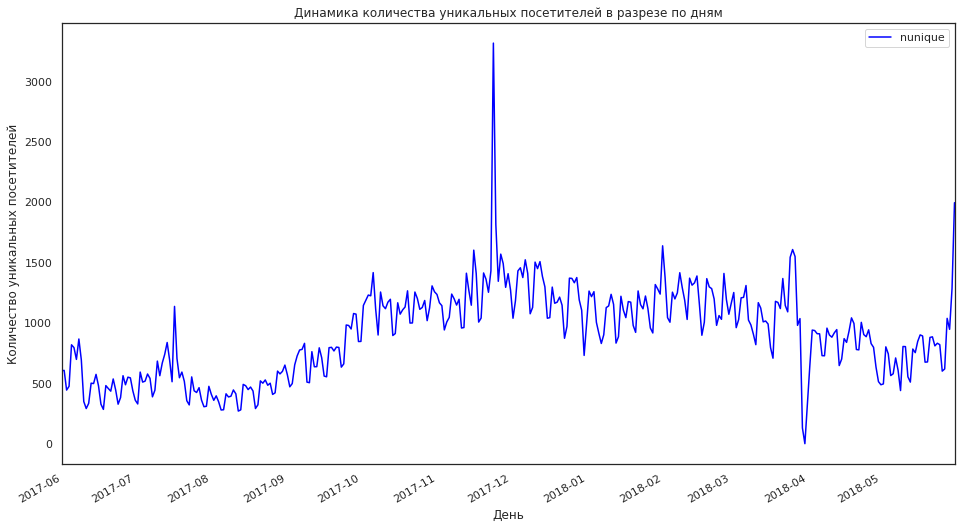

In [77]:
visits_pivot_date = visits.pivot_table(index='session_date', values='uid', # строим сводную таблицу с количеством уникальных
                                      aggfunc={'nunique'})                 # посетителей за каждый день

visits_pivot_date.plot(figsize=(16, 9), color='blue') # строим график динамики показателя DAU за рассматриваемый период
plt.xlabel('День')
plt.ylabel('Количество уникальных посетителей')
plt.title('Динамика количества уникальных посетителей в разрезе по дням')
plt.show()

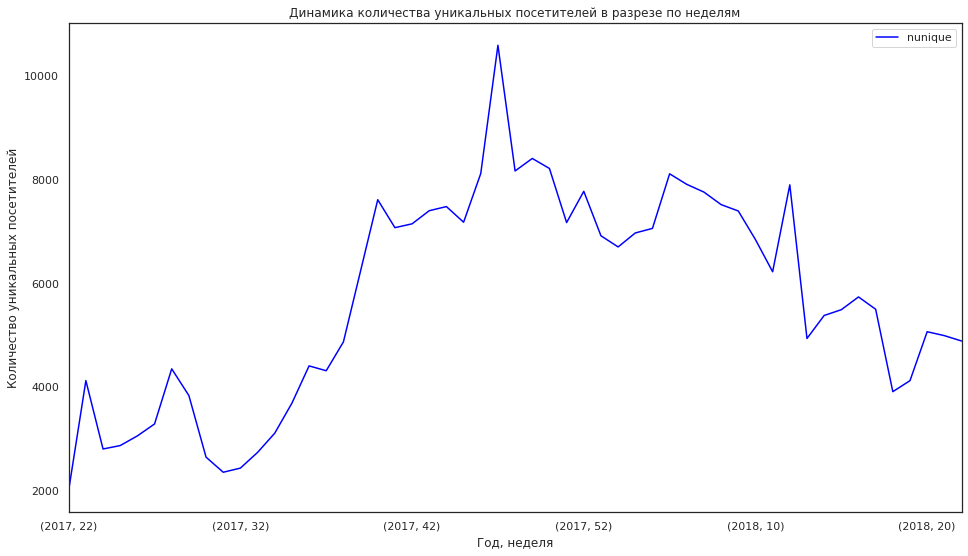

In [78]:
visits_pivot_week = visits.pivot_table(index=['session_year', 'session_week'], # проделываем те же операции с неделями и 
                                       values='uid',                           # месяцами
                                       aggfunc={'nunique'}) 

visits_pivot_week.plot(figsize=(16, 9), color='blue')
plt.xlabel('Год, неделя')
plt.ylabel('Количество уникальных посетителей')
plt.title('Динамика количества уникальных посетителей в разрезе по неделям')
plt.show()

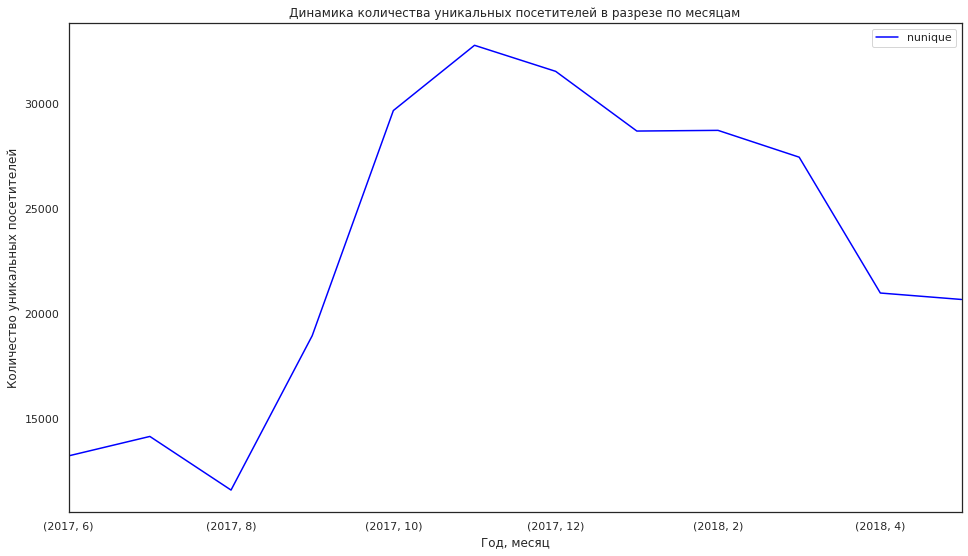

In [79]:
visits_pivot_month = visits.pivot_table(index=['session_year', 'session_month'], 
                                       values='uid',
                                       aggfunc={'nunique'})

visits_pivot_month.plot(figsize=(16, 9), color='blue')
plt.xlabel('Год, месяц')
plt.ylabel('Количество уникальных посетителей')
plt.title('Динамика количества уникальных посетителей в разрезе по месяцам')
plt.show()

Все три графика показывают всплеск пользовательской активности в конце 2017 года. Скорее всего, это связано с желанием покупки билета на развлекательное мероприятие в качестве подарка. При этом на графике, отражающем динамику по дням, можно заметить резкое падение активности в конце апреля. Возможно в этот день с заходом на сайт возникали технические проблемы.

Выясним, сколько раз за день 1 пользователь в среднем заходит на сайт.

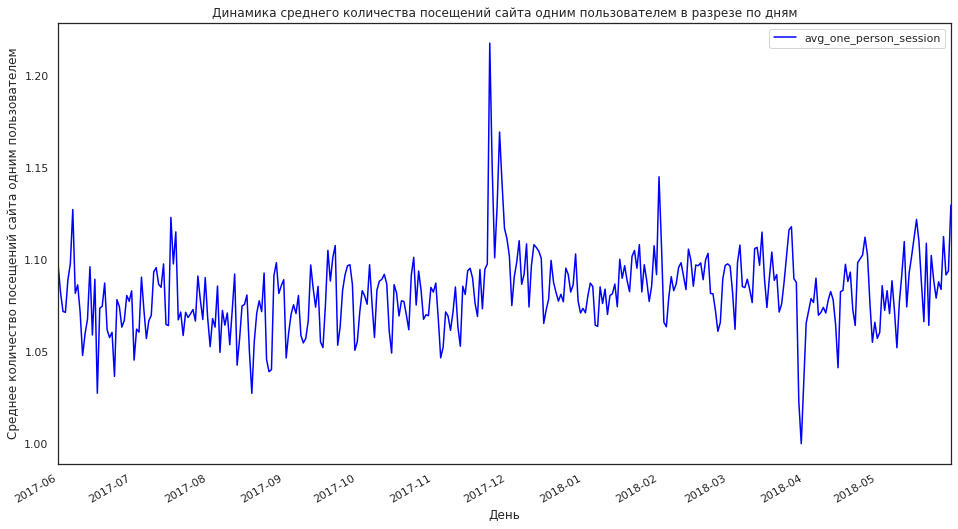

In [80]:
visits_pivot_date = visits.pivot_table(index='session_date', values='uid', # добавляем к подневной сводной таблице столбец с 
                                      aggfunc=['nunique', 'count'])        # общим количеством посещений сайта и считаем 
del visits_pivot_date[('nunique', 'session_date')]                         # среднее количество посещений одним пользователем
visits_pivot_date.columns = ['nunique_uid', 'count_uid']                   # в разрезе по дням
visits_pivot_date['avg_one_person_session'] = visits_pivot_date['count_uid'] / visits_pivot_date['nunique_uid']

visits_pivot_date.plot(y='avg_one_person_session', figsize=(16, 9),        # строим график, отражающий динамику среднего 
                      color='blue')                                        # количества посещений сайта одним пользователем
plt.xlabel('День')                                                         # в разрезе по дням
plt.ylabel('Среднее количество посещений сайта одним пользователем')
plt.title('Динамика среднего количества посещений сайта одним пользователем в разрезе по дням')
plt.show()

Найдем среднюю продолжительность пользовательской сессии.

In [81]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mode() 

0    60
dtype: int64

In [82]:
visits['session_duration_sec'].mean()

643.506488592098

Средняя продолжительность одной сессии - больше 10 минут, однако наиболее часто пользователи проводят на сайте 1 минуту. Посмотрим на распределение продолжительности сессии по пользователям.

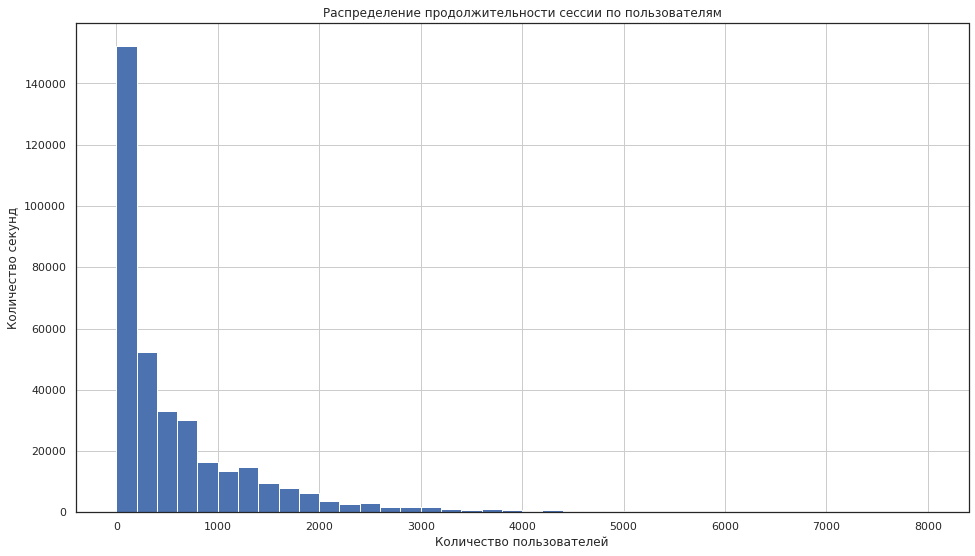

In [83]:
visits['session_duration_sec'].hist(range=(0, 8000), bins=40,
                                    figsize=(16, 9))
plt.xlabel('Количество пользователей')
plt.ylabel('Количество секунд')
plt.title('Распределение продолжительности сессии по пользователям')
plt.show()

Большинство пользователей проводит на сайте менее 1000 секунд.

Рассчитаем Retention Rate. Для этого найдём месяц, в который пользователь зашёл на сайт впервые, и все месяца, в которые пользователи возвращались на сайт. Разделим второй показатель на первый и получим требуемый показатель.

In [84]:
first_activity_date = visits.pivot_table(index='uid',      # построим сводную таблицу, в которой для каждого пользователя будет
                                        values='start_ts', # указано время, когда он первый раз зашёл на сайт
                                        aggfunc='min')
first_activity_date.columns = ['first_time_visit'] # изменим название столбца, чтобы не было двух столбцов с одинаковыми 
                                                   # названиями - в сводной таблице и в таблице visits

In [85]:
visits = visits.join(first_activity_date, on='uid') # объединим датафреймы так, чтобы в изначальном появился столбец со временем
                                                    # первого захода на сайт

In [86]:
visits['first_month_visit'] = visits['first_time_visit'].astype('datetime64[M]') # выделим месяц первого посещения сайта

In [87]:
visits['month_visit'] = visits['start_ts'].astype('datetime64[M]') # для каждого посещения выделим его месяц

In [88]:
visits['cohort_lifetime'] = visits['month_visit'] - visits['first_month_visit'] # для каждого посещения считаем время, 
                                                                                # пройденное с момента первого посещения

In [89]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M') # переводим время, пройденное с момента первого 
                                                                               # посещения, в месяцы

In [90]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') # округляем данные и приводим к целочисленному типу

In [91]:
# создаем таблицу, в которой для каждого месяца первого посещения сайта (для каждой когорты) указано количество пользователей, 
# пользующихся услугами сайта по прошествии определенного количества месяцев
cohorts = visits.groupby(['first_month_visit', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

In [92]:
# для каждой когорты найдём исходное количество пользователей в ней, т.е. тех, кто впервые зашёл на сайт в указанном в
# столбце 'first_month_visit' месяце
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_month_visit', 'uid']] 

In [93]:
initial_users_count = initial_users_count.rename(columns = {'uid': 'cohort_users'}) # переименуем столбец с пользователями для 
                                                                                    # дальнейшего объединения

In [94]:
cohorts = cohorts.merge(initial_users_count, on='first_month_visit') # объединим датафреймы, чтобы в одной таблице было отражено
                                                                     # количество пользователей, впервые зашедших на сайт и тех,
                                                                     # кто на него возвращался через месяца

In [95]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users'] # рассчитаем Retention Rate

In [96]:
retention_pivot = cohorts.pivot_table(index='first_month_visit', # создаем таблицу где для каждой когорты помесячно считаем
                                     columns='cohort_lifetime',  # Retention Rate
                                     values='retention')

In [97]:
retention_pivot.index = retention_pivot.index.strftime('%Y-%m-%d') # исправляем формат даты, чтобы избежать длинных хвостов
                                                                   # в столбце y на визуализации

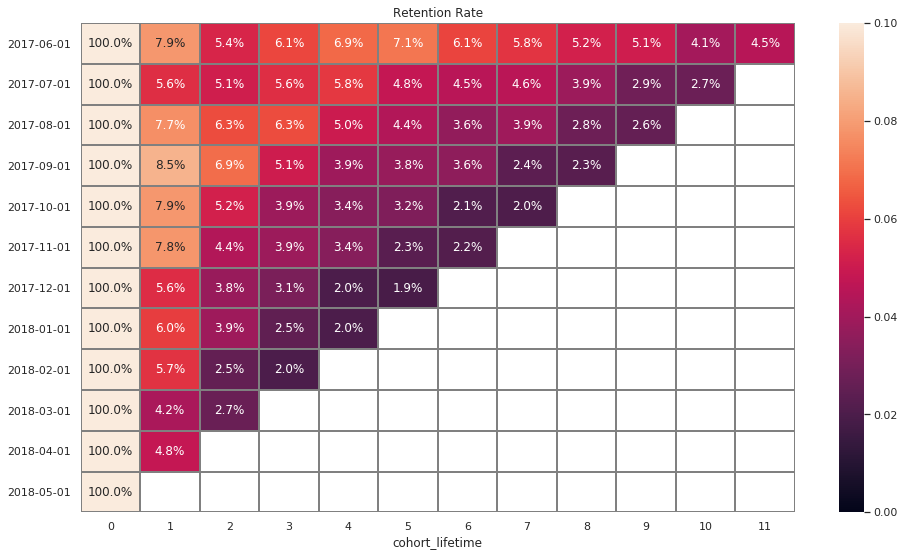

In [98]:
sns.set(style='white')      # визуализируем полученные результаты
plt.figure(figsize=(16, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1)

На первый взгляд кажется, что с удержанием клиентов у сайта существуют проблемы. На следующий месяц на сайт Яндекс.Афиши возвращаются меньше 10% пользователей. С другой стороны, много ли существует людей, которые покупают билеты на развлекательные мероприятия ежемесячно? Подавляющее большинство людей делает это реже, поэтому на основании полученных данных нельзя сделать однозначный вывод о плохой маркетинговой работе.

<a name="subparagraph5"></a> 
### 2.2 Метрики электронной коммерции

Найдем, сколько времени проходит с момента первого посещения сайта до первой покупки.

In [99]:
first_order = orders.pivot_table(index='uid',    # строим сводную таблицу, которая для каждого пользователя показывает время
                                values='buy_ts', # первой совершенной покупки
                                aggfunc='min')
first_order.columns = ['first_order']

In [100]:
first_visit_and_order = first_activity_date.merge(first_order, on='uid').reset_index() # объединяем таблицы, в которых будут 
                                                                                       # два времени: первого захода на сайт и 
                                                                                       # первой покупки

In [101]:
# находим разницу между двумя временными величинами
first_visit_and_order['from_visit_to_order'] = (first_visit_and_order['first_order'] - 
                                                first_visit_and_order['first_time_visit']).dt.seconds

In [102]:
# смотрим на статистику времени, которое проходит с первого визита до первой поекупи
first_visit_and_order['from_visit_to_order'].describe() 

count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: from_visit_to_order, dtype: float64

In [103]:
# смотрим на наиболее частое время, проходящее от визита до покупки
first_visit_and_order['from_visit_to_order'].mode()

0    60
dtype: int64

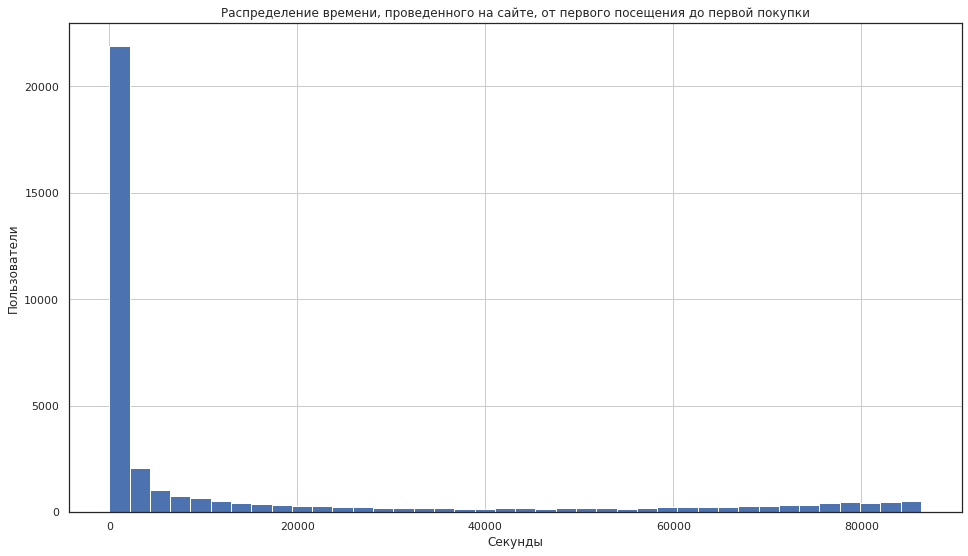

In [104]:
# строим распределение этого времени
first_visit_and_order['from_visit_to_order'].hist(bins=40, figsize=(16, 9))
plt.xlabel('Секунды')
plt.ylabel('Пользователи')
plt.title('Распределение времени, проведенного на сайте, от первого посещения до первой покупки')
plt.show()

В среднем между заходом на сайт и покупкой проходит около 4-х часов, однако это вызвано большим разбросом величин. Наиболее частое время, так же как и в продолжительности сессии, - 1 минута. Пользователи не сильно задерживаются на сайте. Вывод соотносится с проведенным ранее распределением продолжительности сессии.

Найдем среднее количество покупок на одного клиента за период в 6 месяцев.

In [105]:
# переводим время покупки в месяцы
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [106]:
# добавляем в таблицу с заказами время первого заказа, совершенного пользователем 
orders = orders.merge(first_order, on='uid')

In [107]:
# переводим это время в месяц
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')

In [108]:
# добавляем столбец с разницей между месяцем определенной покупки и 
# месяцем первой покупки
orders['cohort_lifetime'] = orders['order_month'] - orders['first_order_month']

In [109]:
# переводим этот столбец в месяц
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1, 'M')

In [110]:
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int')

In [111]:
# смотрим на количество пользователей, покупающих товар в разные жизненные циклы когорт
cohorts = orders.groupby(['first_order_month', 'cohort_lifetime']).agg({'uid':'count'}).reset_index()

In [112]:
cohorts

,first_order_month,cohort_lifetime,uid
0,2017-06-01,0,2354
1,2017-06-01,1,177
2,2017-06-01,2,174
3,2017-06-01,3,226
4,2017-06-01,4,292
...,...,...,...
74,2018-03-01,2,176
75,2018-04-01,0,2495
76,2018-04-01,1,195
77,2018-05-01,0,3249


In [113]:
# приводим таблицу в наглядный для когортного анализа вид
orders_cohort = cohorts.pivot_table(index='first_order_month',
                                   columns='cohort_lifetime',
                                   values='uid').cumsum(axis=1).copy()
orders_cohort

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2354.0,2531.0,2705.0,2931.0,3223.0,3441.0,3717.0,3891.0,4103.0,4256.0,4352.0,4438.0
2017-07-01,2186.0,2286.0,2406.0,2510.0,2582.0,2664.0,2725.0,2775.0,2833.0,2857.0,2910.0,NaN
2017-08-01,1533.0,1641.0,1741.0,1822.0,1907.0,1969.0,2018.0,2096.0,2142.0,2188.0,NaN,NaN
2017-09-01,2933.0,3152.0,3313.0,3477.0,3544.0,3653.0,3761.0,3817.0,3878.0,NaN,NaN,NaN
2017-10-01,4964.0,5278.0,5440.0,5562.0,5691.0,5794.0,5880.0,6005.0,NaN,NaN,NaN,NaN
2017-11-01,4813.0,5210.0,5392.0,5603.0,5739.0,5798.0,5900.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5052.0,5322.0,5524.0,5703.0,5789.0,5894.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3783.0,4007.0,4166.0,4230.0,4308.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4095.0,4317.0,4400.0,4470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В данной таблице в качестве значений мы получили количество покупок, которые сделали пользователи, в разрезе по месячным когортам (напомню: по когортам люди разбиты в соответствии с тем, в какой месяц они совершили первую покупку). В данном датафрейме лишь пользователи, которые находятся в когортах, относящихся к месяцам 2017 года, пользовались сайтом на протяжении 6 месяцев. Найдём уникальное количество пользователей в каждой когорте и разделим столбец с накопительным количеством покупок за 6 месяцев на количество уникальных пользователей на 6-ой месяц.

In [114]:
# проделываем те же шаги, только вместо общего количества пользователей находим количество уникальных
uids_unique = orders.groupby(['first_order_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [115]:
uids_unique = uids_unique.pivot_table(index='first_order_month',
                                     columns='cohort_lifetime',
                                     values='uid').cumsum(axis=1)

In [116]:
uids_unique

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2023.0,2084.0,2134.0,2188.0,2276.0,2343.0,2405.0,2452.0,2510.0,2555.0,2600.0,2653.0
2017-07-01,1923.0,1975.0,2032.0,2096.0,2145.0,2183.0,2219.0,2258.0,2300.0,2322.0,2348.0,NaN
2017-08-01,1370.0,1428.0,1481.0,1525.0,1565.0,1597.0,1627.0,1671.0,1690.0,1721.0,NaN,NaN
2017-09-01,2581.0,2711.0,2811.0,2885.0,2937.0,3001.0,3067.0,3104.0,3147.0,NaN,NaN,NaN
2017-10-01,4340.0,4546.0,4669.0,4761.0,4854.0,4926.0,4982.0,5049.0,NaN,NaN,NaN,NaN
2017-11-01,4081.0,4303.0,4423.0,4529.0,4610.0,4658.0,4720.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,4383.0,4529.0,4632.0,4729.0,4779.0,4842.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3373.0,3487.0,3570.0,3613.0,3658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3651.0,3769.0,3827.0,3866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Применив когортный анализ, для каждой когорты мы посчитали общее количество покупок и общее количество покупателей за каждый месяц её "жизни". Осталось лишь разделить первое значение на второе и получить среднее количество покупок на одного клиента за 6 месяцев "жизни" когорты. 

In [117]:
orders_cohort[5] / uids_unique[5]

first_order_month
2017-06-01    1.468630
2017-07-01    1.220339
2017-08-01    1.232937
2017-09-01    1.217261
2017-10-01    1.176208
2017-11-01    1.244740
2017-12-01    1.217266
2018-01-01         NaN
2018-02-01         NaN
2018-03-01         NaN
2018-04-01         NaN
2018-05-01         NaN
2018-06-01         NaN
Name: 5, dtype: float64

Значение выбивается лишь для первой когорты - с июня по декабрь среднее количество покупок на одного клиента близко к 1.5. В остальных когортах на 1 клиента в среднем совершается около 1.2 покупок.

Рассчитаем среднюю выручку с пользователя.

In [118]:
orders.groupby('uid').agg({'revenue':'mean'}).reset_index()

,uid,revenue
0,313578113262317,0.550000
1,1575281904278712,1.525000
2,2429014661409475,73.330000
3,2464366381792757,2.440000
4,2551852515556206,5.495000
...,...,...
36518,18445147675727495770,3.050000
36519,18445407535914413204,0.293333
36520,18445601152732270159,4.220000
36521,18446156210226471712,9.780000


Рассмотрим, как средняя выручка меняется с течением времени.

In [119]:
revenue_per_month = orders.groupby('order_month').agg({'revenue':'mean'}).reset_index()

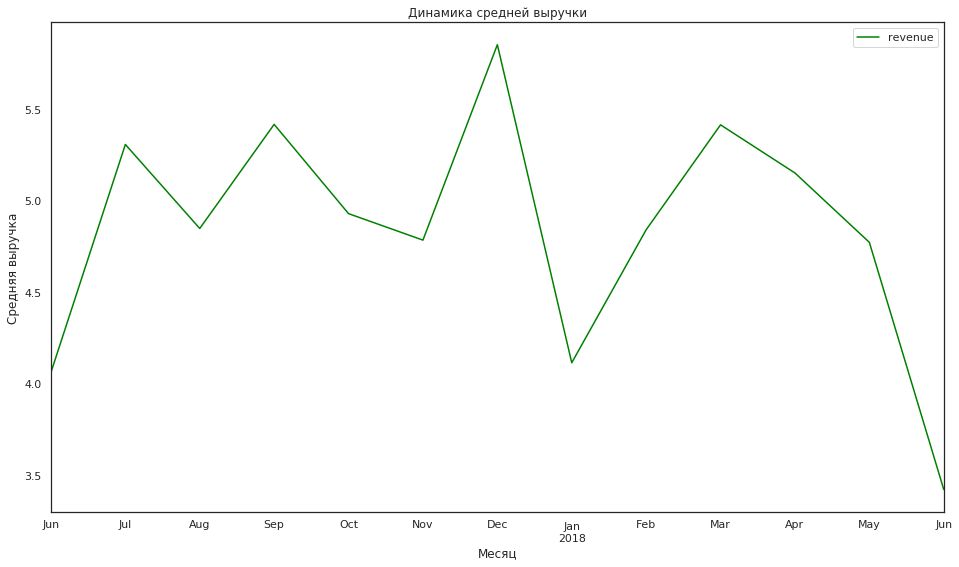

In [120]:
revenue_per_month.plot(x='order_month',
                      y='revenue', 
                      figsize=(16, 9), color='green')
plt.xlabel('Месяц')
plt.ylabel('Средняя выручка')
plt.title('Динамика средней выручки')
plt.show()

Динамика выручки по месяцам демонстрирует, что никаких значительных скачков не происходит. Каждый месяц её значение "гуляет" вокруг среднего.

Найдем накопительный LTV по когортам.

In [121]:
# находим выручку, полученную с каждой когорты на каждый её период жизни
orders_cohorts_for_ltv = orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

In [122]:
first_order = first_order.reset_index()

In [123]:
# переводим дату первой покупки в месяц
first_order['first_order'] = first_order['first_order'].astype('datetime64[M]')

In [124]:
# находим, сколько клиентов совершило первую покупку по когортам
cohort_sizes = first_order.groupby('first_order').agg({'uid':'nunique'}).reset_index()

In [125]:
# переименовываем столбцы для объединения
cohort_sizes = cohort_sizes.rename(columns=({'first_order':'first_order_month', 'uid':'n_buyers'}))

In [126]:
# объединяем таблицы
orders_cohorts_for_ltv = orders_cohorts_for_ltv.merge(cohort_sizes, on='first_order_month')

In [127]:
# выделяем жизненный период когорты так же, как и в предыдущем когортном анализе
orders_cohorts_for_ltv['age'] = orders_cohorts_for_ltv['order_month'] - orders_cohorts_for_ltv['first_order_month']

In [128]:
orders_cohorts_for_ltv['age'] = orders_cohorts_for_ltv['age'] / np.timedelta64(1, 'M')

In [129]:
orders_cohorts_for_ltv['age'] = orders_cohorts_for_ltv['age'].round().astype('int')

In [130]:
# делим выручку на уникальное количество пользователей - так получим сумму, которую 
# в среднем приносит один пользователь. Это и есть LTV
orders_cohorts_for_ltv['ltv'] = orders_cohorts_for_ltv['revenue'] / orders_cohorts_for_ltv['n_buyers']

In [131]:
# строим таблицу с накопительным ltv по когортам
output = orders_cohorts_for_ltv.pivot_table(index='first_order_month',
                                           columns='age',
                                           values='ltv').cumsum(axis=1).round(2)

In [132]:
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,NaN
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,NaN,NaN
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,NaN,NaN,NaN
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,NaN,NaN,NaN,NaN
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.40,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.74,5.00,5.92,6.99,7.30,7.64,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.14,4.43,4.73,4.88,4.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.16,4.44,4.51,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


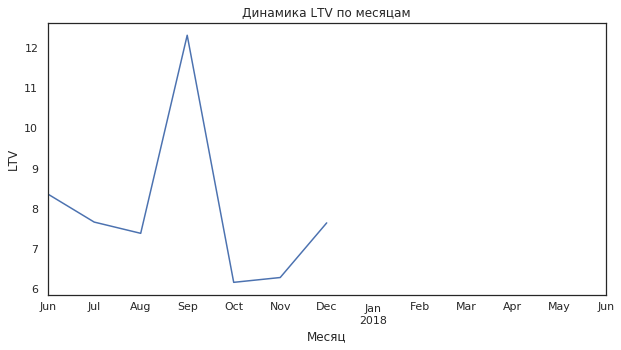

In [133]:
# смотрим на разницу между накопительным LTV за одинаковый 6-месячный период
output[5].plot(figsize=(10,5))
plt.xlabel('Месяц')
plt.ylabel('LTV')
plt.title('Динамика LTV по месяцам')
plt.show()

Взглянув на динамику LTV бросается в глаза резкий выпад показателя для сентябрьской когорты относительно остальных когорт. Среднее количество покупок пользователей данной когорты, как было видно ранее, не выделялось относительно остальных, однако выручки покупатели этой когорты принесли больше. 

<a name="subparagraph6"></a> 
### 2.3 Маркетинговые метрики

Посчитаем общую сумму расходов на маркетинг, распределение трат по источникам и их изменение во времени.

In [134]:
costs_total = costs['costs'].sum()
print('Общая сумма расходов на маркетинг: {:.2f}'.format(costs_total))

Общая сумма расходов на маркетинг: 329131.62


In [135]:
# строим таблицу с суммой расходов на маркетинг по источникам
costs_per_source = costs.pivot_table(index='source_id',
                                     values='costs',
                                     aggfunc='sum')

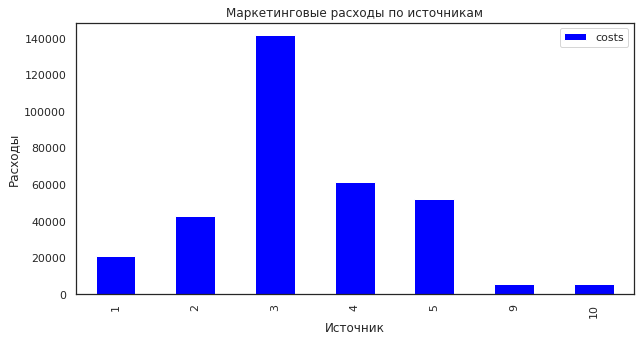

In [137]:
# делаем визуализацию данных
costs_per_source.plot(kind='bar', color='blue',
                     figsize=(10, 5))
plt.title('Маркетинговые расходы по источникам')
plt.xlabel('Источник')
plt.ylabel('Расходы')
plt.show()

In [139]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')

<div class="alert alert-warning">
    
**Комментарий ревьюера**
    
Для визуализации затрат по источникам на мой взгляд здесь лучше подойдет линейный график, он будет выглядеить гораздно понятнее. Попробуй его построить, можешь быть тебе он тоже больше понравится и покажется удобнее</div>

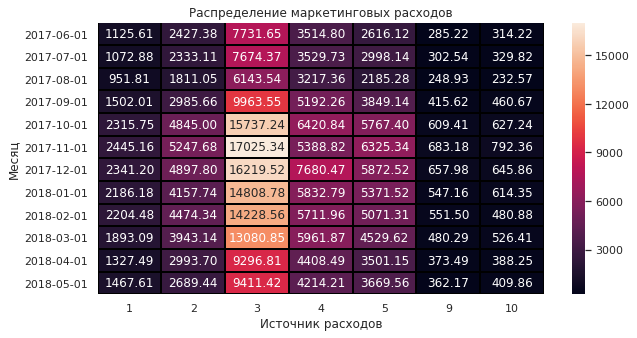

In [140]:
# чертим тепловую карту маркетинговых расходов по источемкам,
# показывающую их изменение за 12 месяцев
costs_pivot = costs.pivot_table(index='dt_month',
                 columns='source_id',
                 values='costs',
                 aggfunc='sum')
costs_pivot.index = costs_pivot.index.strftime('%Y-%m-%d')
plt.figure(figsize=(10, 5))
ax = sns.heatmap(costs_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')
ax.set_xlabel('Источник расходов')
ax.set_ylabel('Месяц')
ax.set_title('Распределение маркетинговых расходов')
plt.show()

Самые большие маркетинговые расходы для всех источников приходились на период с октября по декабрь. При этом тепловая карта более явно показывает разницу между тратами на 3-ий источник и все остальные.

Рассчитаем CAC.

In [141]:
# выделяем для каждого пользователя время первого визита в отдельный датафрейм
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()

In [142]:
# добавляем новую колонку, которая поможем сделать срез позже при объединении
first_visits['is_first'] = True

In [143]:
# объединяем колонки первых и всех визитов
visits = visits.merge(first_visits, how='left', on=['uid', 'start_ts'])

In [144]:
# вырезаем только первые визиты
first_visits_with_source = visits.loc[visits['is_first'] == True]

In [145]:
# берем из получившегося датафрейма те колонки, которые понадобятся в дальнейшем анализе
first_visits_with_source = first_visits_with_source[['uid', 'source_id', 'device']]

In [146]:
orders = orders.merge(first_visits_with_source, on='uid')

In [147]:
# находим уникальное количество пользователей для каждого источника
orders_and_sources = orders.groupby(['source_id'])['uid'].nunique().reset_index()
orders_and_sources = orders_and_sources.rename(columns={'uid':'unique_buyers'})

In [148]:
# находим сумму расходов на каждый источник
costs_and_sources = costs.groupby('source_id')['costs'].sum().reset_index()

In [149]:
# объединяем 2 датафрема
costs_and_sources = orders_and_sources.merge(costs_and_sources, on='source_id')

In [150]:
# делим сумму расходов на количество уникальных пользователей - это и будет показатель cac
costs_and_sources['cac_per_source'] = costs_and_sources['costs'] / costs_and_sources['unique_buyers']

In [151]:
costs_and_sources.set_index('source_id')

,unique_buyers,costs,cac_per_source
source_id,,,
1,2899,20833.27,7.186364
2,3506,42806.04,12.209367
3,10473,141321.63,13.493901
4,10296,61073.60,5.931779
5,6931,51757.10,7.467479
9,1088,5517.49,5.071222
10,1329,5822.49,4.381106


Расчитаем ROMI, поделив LTV на CAC. 

In [152]:
# находим накопительное количество уникальных пользователей по когортам
# в разрезе источников
buyers_per_sources_and_cohorts = orders.pivot_table(index='source_id',
                                                    columns='cohort_lifetime',
                                                    values='uid',
                                                    aggfunc='nunique').cumsum(axis=1)

In [153]:
buyers_per_sources_and_cohorts

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,2899.0,3028.0,3113.0,3183.0,3228.0,3277.0,3311.0,3342.0,3367.0,3380.0,3395.0,3405.0
2,3506.0,3689.0,3810.0,3908.0,4002.0,4077.0,4135.0,4175.0,4200.0,4217.0,4233.0,4246.0
3,10473.0,10801.0,11014.0,11155.0,11274.0,11359.0,11440.0,11505.0,11544.0,11561.0,11576.0,11590.0
4,10296.0,10619.0,10810.0,10967.0,11080.0,11172.0,11242.0,11286.0,11317.0,11342.0,11355.0,11364.0
5,6931.0,7132.0,7255.0,7346.0,7425.0,7480.0,7524.0,7560.0,7585.0,7602.0,7611.0,7618.0
7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1088.0,1161.0,1219.0,1262.0,1303.0,1327.0,1346.0,1358.0,1372.0,1380.0,1383.0,NaN
10,1329.0,1358.0,1372.0,1385.0,1392.0,1396.0,1402.0,1408.0,1411.0,1412.0,NaN,NaN


In [154]:
# находим накопительное значение выручки по кгортам в разрезе источников
revenue_per_sources_and_cohorts = orders.pivot_table(index='source_id',
                                                    columns='cohort_lifetime',
                                                    values='revenue',
                                                    aggfunc='sum').cumsum(axis=1)

In [155]:
# делим выручку на количество уникальных пользователей - получаем LTV
ltv_per_sources_in_cohorts = revenue_per_sources_and_cohorts / buyers_per_sources_and_cohorts
ltv_per_sources_in_cohorts

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.244695,6.861080,7.407067,7.907201,8.160325,8.261996,8.402649,8.642358,8.860642,8.992822,9.064250,9.130852
2,6.610839,7.630678,8.866617,10.091412,10.468418,10.732902,10.892837,10.954108,10.999150,11.009455,11.061136,11.051251
3,4.488594,4.613896,4.662713,4.696388,4.712821,4.721391,4.712691,4.708689,4.709723,4.709307,4.707214,4.703299
4,4.555284,4.597871,4.607730,4.665327,4.711264,4.774038,4.902122,4.919865,4.923719,4.948543,4.990028,4.989161
5,4.840905,4.949759,5.062420,6.415632,6.532443,6.710201,6.787084,6.833827,6.857757,6.904455,6.908321,6.907852
7,1.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.892509,3.912524,3.973864,4.030174,4.022717,4.054785,4.085312,4.115110,4.177332,4.166703,4.164425,NaN
10,3.163792,3.159904,3.154242,3.161733,3.162960,3.163417,3.157853,3.155973,3.151644,3.151792,NaN,NaN


In [156]:
# значение CAC по источникам у нас есть
cac_per_source = costs_and_sources.set_index('source_id')[['cac_per_source']]

In [157]:
# уберем данные по 7 источнику, т.к. они явно неполные, и в CAC по источникам
# источника с таким номером вообще нет
ltv_per_sources_in_cohorts = ltv_per_sources_in_cohorts.drop(7, axis='rows')

In [158]:
# перебираем все колонки из LTV и делим на значение CAC - получаем ROMI 
# по когортам в разрезе источников
for column in ltv_per_sources_in_cohorts:
    ltv_per_sources_in_cohorts[column] = ltv_per_sources_in_cohorts[column] / cac_per_source['cac_per_source']

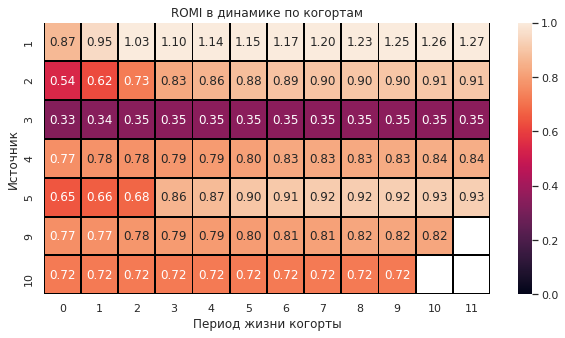

In [159]:
# визуализируем ROMI
plt.figure(figsize=(10, 5))
ax = sns.heatmap(ltv_per_sources_in_cohorts, annot=True, fmt='.2f',
                 linewidths=1, linecolor='black', vmin=0, vmax=1)
ax.set_xlabel('Период жизни когорты')
ax.set_ylabel('Источник')
ax.set_title('ROMI в динамике по когортам')
plt.show()

Согласно полученной таблице, маркетинговые инвестиции окупаются только для первого источника. Для второго и пятого они близки к единице. В третий источник вложено больше всего маркетинговых средств, однако окупаются они очень плохо.

### 2.4 Анализ посещений с разных видов устройств.

In [107]:
visits_device = visits[['device', 'uid', 'source_id', 'start_ts', 'end_ts']]

<div class="alert alert-warning">
    
**Комментарий ревьюера**
    
Чтобы избужать системных предупреждений, можешь воспользоваться `copy()`
`visits_device = visits_device.copy()`</div>

In [108]:
visits_device['session_duration'] = (visits_device['end_ts'] - visits_device['start_ts'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
visits_device['session_duration'] = visits_device['session_duration'] / np.timedelta64(1, 'm')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
visits_device['session_duration'] = visits_device['session_duration'].astype('int')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [111]:
visits_desktop = visits_device.loc[visits_device.loc[:, 'device'] == 'desktop']

In [112]:
visits_desktop = visits_desktop.loc[visits_desktop.loc[:, 'session_duration'] > 0]

In [113]:
visits_desktop['session_duration'].describe()

count    238222.000000
mean         12.918811
std          18.251837
min           1.000000
25%           2.000000
50%           7.000000
75%          17.000000
max         711.000000
Name: session_duration, dtype: float64

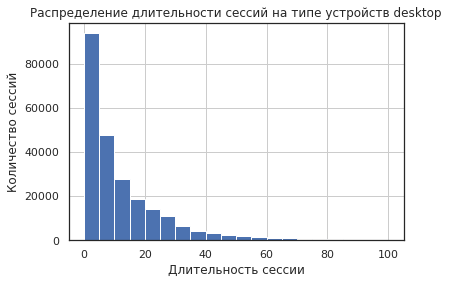

In [114]:
visits_desktop['session_duration'].hist(bins=20, range=(0,100))
plt.xlabel('Длительность сессии')
plt.ylabel('Количество сессий')
plt.title('Распределение длительности сессий на типе устройств desktop')
plt.show()

In [115]:
visits_touch = visits_device.loc[visits_device.loc[:, 'device'] == 'touch']

In [116]:
visits_touch['session_duration'].describe()

count    96833.000000
mean         7.992957
std         12.542629
min          0.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        514.000000
Name: session_duration, dtype: float64

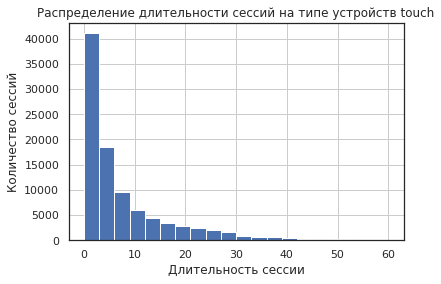

In [117]:
visits_touch['session_duration'].hist(bins=20, range=(0,60))
plt.xlabel('Длительность сессии')
plt.ylabel('Количество сессий')
plt.title('Распределение длительности сессий на типе устройств touch')
plt.show()

Яндекс.Афишу чаще посещают с типа устройства desktop. На этом же типе устройств дольше и средняя и медианная длительность посещений.

<a name="paragraph3"></a> 
# 3. Выводы

### Вывод №1
Наиболее популярные источники трафика среди пользователей: под номером 3 и 4. Однако в эти источники было вложено больше всего маркетинговых инвестиций, которые в итоге не окупились. ROMI показал, что наиболее перспективными источниками являются те, что под номерами 1, 2 и 5, т.к. вложения в них либо окупаются, либо близки к тому, чтобы окупиться. Таким образом, анализ показал, что стоит сделать упор на источники 1, 2 и 5. 

### Вывод № 2
Продуктовые метрики показали следующее:
1) наиболее интенсивный период пользования сайтом Яндекс.Афиши - конец года

2) в среднем пользователи заходят на сайт чуть больше 1 раза

3) наиболее частая продолжительность сессии - 1 минута

4) после первого использования менее 10% пользователей возвращаются на сайт ещё раз

### Вывод № 3
Наиболее перспективными для компании являются июньская и сентябрьская когорты. Пользователи, зашедшие впервые на сайт в июне и сентябре приносят больше выручки, чем остальные (накопительные значения LTV по когортам это демонстрируют). А вот те, кто впервые зашёл на сайт после Нового Года - приносят меньше денег за свой жизненный период, чем другие когорты за тот же период.  

### Вывод № 4
Пользователи чаще заходят на Яндекс.Афишу с типов устройств desktop. На этих же устройствах в среднем более длительные сессии.